## 🧠 Spiking Heidelberg Digits (SHD) Classification with **SNNtorch**

---

### 📌 Project Overview

This notebook demonstrates **spiking neural network (SNN)** classification on the
**Spiking Heidelberg Digits (SHD)** dataset using modern neuromorphic tooling.

---

### ⚙️ Step 1: Environment Setup & Reproducibility

We begin by configuring the environment to ensure **deterministic behavior** and
**reproducible experimental results**.

---

### 👤 Author

**AI Research Engineer**

---

### 📊 Dataset

**Spiking Heidelberg Digits (SHD)**

---

### 🧩 Framework & Libraries

* **SNNtorch**
* **PyTorch**
* **Tonic**

In [1]:
# ============================================================================
# PART A: Install Required Libraries
# ============================================================================
print("=" * 80)
print("INSTALLING DEPENDENCIES")
print("=" * 80)

import sys
import subprocess

def install_package(package_name, import_name=None):
    """Install package if not already available."""
    if import_name is None:
        import_name = package_name
    
    try:
        __import__(import_name)
        print(f"✓ {package_name} already installed")
    except ImportError:
        print(f"Installing {package_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package_name])
        print(f"✓ {package_name} installed successfully")

# Install required packages
install_package("snntorch")
install_package("tonic")
install_package("h5py")
install_package("celluloid")  # For animation support

print("\n" + "=" * 80)
print("ALL DEPENDENCIES INSTALLED")
print("=" * 80 + "\n")

# ============================================================================
# PART B: Import All Required Modules
# ============================================================================
print("Importing libraries...")

# Standard Libraries
import os
import random
import warnings
from pathlib import Path
from typing import Tuple, Dict, List, Optional

# Numerical & Data Processing
import numpy as np
import pandas as pd
import h5py

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from IPython.display import clear_output

# PyTorch & Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# SNNTorch - Spiking Neural Networks
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

# Tonic - Neuromorphic Data Loading
import tonic
from tonic import DiskCachedDataset

# Training utilities
from tqdm.auto import tqdm
import time

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully\n")

# ============================================================================
# PART C: Set Global Random Seeds for Reproducibility
# ============================================================================
print("=" * 80)
print("CONFIGURING REPRODUCIBILITY (seed=42)")
print("=" * 80)

SEED = 42

def set_seed(seed: int = 42):
    """
    Set random seeds for complete reproducibility across:
    - Python's random module
    - NumPy
    - PyTorch (CPU and CUDA)
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    
    # Configure PyTorch for deterministic operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Set environment variable for Python hashing
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    print(f"✓ Global seed set to {seed}")
    print("✓ PyTorch configured for deterministic operations")
    print("✓ CUDNN deterministic mode enabled")
    print("✓ CUDNN benchmark mode disabled")

set_seed(SEED)

# ============================================================================
# PART D: GPU Detection & Initialization
# ============================================================================
print("\n" + "=" * 80)
print("GPU DETECTION & INITIALIZATION")
print("=" * 80)

# Detect available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

if torch.cuda.is_available():
    print(f"✓ GPU Detected: {torch.cuda.get_device_name(0)}")
    print(f"✓ CUDA Version: {torch.version.cuda}")
    print(f"✓ Number of GPUs: {torch.cuda.device_count()}")
    print(f"✓ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"✓ Current GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1e9:.4f} GB")
    print(f"✓ Current GPU Memory Cached: {torch.cuda.memory_reserved(0) / 1e9:.4f} GB")
else:
    print("⚠ WARNING: GPU not available. Training will be slow on CPU.")
    print("Consider enabling GPU acceleration in Kaggle Notebook settings.")

# ============================================================================
# PART E: Configure Visualization Settings
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION CONFIGURATION")
print("=" * 80)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

print("✓ Visualization settings configured")

# ============================================================================
# PART F: Define Kaggle Directory Paths
# ============================================================================
print("\n" + "=" * 80)
print("DIRECTORY STRUCTURE")
print("=" * 80)

# Define paths for Kaggle environment
BASE_DIR = Path("/kaggle/working")
DATA_DIR = Path("/kaggle/input")
OUTPUT_DIR = BASE_DIR / "outputs"
MODEL_DIR = BASE_DIR / "models"
CACHE_DIR = BASE_DIR / "cache"

# Create necessary directories
for directory in [OUTPUT_DIR, MODEL_DIR, CACHE_DIR]:
    directory.mkdir(parents=True, exist_ok=True)
    print(f"✓ Created/Verified: {directory}")

# ============================================================================
# PART G: System Information Summary
# ============================================================================
print("\n" + "=" * 80)
print("SYSTEM INFORMATION SUMMARY")
print("=" * 80)

print(f"Python Version: {sys.version.split()[0]}")
print(f"PyTorch Version: {torch.__version__}")
print(f"snntorch Version: {snn.__version__}")
print(f"Tonic Version: {tonic.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Device: {device}")
print(f"Working Directory: {BASE_DIR}")
print(f"Random Seed: {SEED}")

print("\n" + "=" * 80)
print("ENVIRONMENT SETUP COMPLETE ✓")
print("=" * 80)
print("\nReady to proceed to data acquisition and preprocessing.\n")

INSTALLING DEPENDENCIES
Installing snntorch...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 2.8 MB/s eta 0:00:00
✓ snntorch installed successfully
Installing tonic...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.2/106.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.9/131.9 kB 5.2 MB/s eta 0:00:00
✓ tonic installed successfully
✓ h5py already installed
Installing celluloid...
✓ celluloid installed successfully

ALL DEPENDENCIES INSTALLED

Importing libraries...
✓ All libraries imported successfully

CONFIGURING REPRODUCIBILITY (seed=42)
✓ Global seed set to 42
✓ PyTorch configured for deterministic operations
✓ CUDNN deterministic mode enabled
✓ CUDNN benchmark mode disabled

GPU DETECTION & INITIALIZATION
Device: cuda
✓ GPU Detected: Tesla T4
✓ CUDA Version: 12.4
✓ Number of GPUs: 2
✓ GPU Memory: 15.83 GB
✓ Current GPU Memory Allocated: 0.0000 GB
✓ Current GPU Memory

## 📥 Step 2: Data Acquisition & Preprocessing

---

### 🎯 Objective

Download and preprocess the **Spiking Heidelberg Digits (SHD)** dataset for training and evaluation.

---

### 📊 Dataset Description

The **SHD dataset** consists of **event-based spike trains** generated from spoken digits:

* **Digits:** 0–9 (German language)
* **Input Channels:** 700
* **Data Type:** Spike events (neuromorphic / event-driven)
* **Representation:** Temporal spike trains per input neuron

Each sample encodes auditory information as a **sequence of spike events**, making it well-suited for **spiking neural network (SNN)** models.


In [3]:
# ============================================================================
# PART A: Dataset Overview & Information
# ============================================================================
print("=" * 80)
print("SPIKING HEIDELBERG DIGITS (SHD) DATASET")
print("=" * 80)

dataset_info = """
Dataset: Spiking Heidelberg Digits (SHD)
Task: Audio digit classification (0-9 in German)
Classes: 20 classes (10 digits × 2 speakers)
Input: Spike trains from 700 audio channels
Encoding: Cochlear model converting audio to spike events
Train samples: ~8,156 samples
Test samples: ~2,264 samples
Duration: Variable (~1 second typical)
Format: HDF5 files with spike times and neuron indices

Key Characteristics:
- Neuromorphic representation of audio
- Sparse spike events (not dense tensors)
- Temporal information encoded in spike timing
- Requires time-binning for SNN processing
"""

print(dataset_info)

# ============================================================================
# PART B: Download SHD Dataset Using Tonic
# ============================================================================
print("=" * 80)
print("DOWNLOADING SHD DATASET")
print("=" * 80)

# Define data directory
SHD_DATA_DIR = BASE_DIR / "shd_data"
SHD_DATA_DIR.mkdir(exist_ok=True)

print(f"Download location: {SHD_DATA_DIR}\n")

# Download training and test sets
print("Downloading training set...")
train_dataset_raw = tonic.datasets.SHD(
    save_to=str(SHD_DATA_DIR),
    train=True
)

print("\nDownloading test set...")
test_dataset_raw = tonic.datasets.SHD(
    save_to=str(SHD_DATA_DIR),
    train=False
)

print("\n✓ Dataset downloaded successfully")
print(f"✓ Train samples: {len(train_dataset_raw)}")
print(f"✓ Test samples: {len(test_dataset_raw)}")

# ============================================================================
# PART C: Inspect Raw Data Structure
# ============================================================================
print("\n" + "=" * 80)
print("INSPECTING RAW DATA STRUCTURE")
print("=" * 80)

# Get a sample from the dataset
sample_events, sample_label = train_dataset_raw[0]

print(f"\nSample Label (Class): {sample_label}")
print(f"\nEvent Data Structure:")
print(f"Type: {type(sample_events)}")
print(f"Dtype: {sample_events.dtype}")
print(f"Shape: {sample_events.shape}")
print(f"Number of spike events: {len(sample_events)}")

print(f"\nEvent Fields:")
for field_name in sample_events.dtype.names:
    print(f"  - {field_name}: {sample_events[field_name][:5]} ...")

# Extract key statistics
neuron_indices = sample_events['x']
spike_times = sample_events['t']

print(f"\nSample Statistics:")
print(f"  Neuron indices range: {neuron_indices.min()} to {neuron_indices.max()}")
print(f"  Number of input channels: {neuron_indices.max() + 1}")
print(f"  Spike times range: {spike_times.min():.2f} to {spike_times.max():.2f} μs")
print(f"  Duration: {(spike_times.max() - spike_times.min()) / 1e6:.4f} seconds")
print(f"  Total spikes: {len(spike_times)}")
print(f"  Average firing rate: {len(spike_times) / (neuron_indices.max() + 1):.2f} spikes/neuron")

# ============================================================================
# PART D: Analyze Dataset Statistics
# ============================================================================
print("\n" + "=" * 80)
print("DATASET STATISTICS ANALYSIS")
print("=" * 80)

def analyze_dataset_stats(dataset, name="Dataset", num_samples=500):
    """Analyze key statistics across multiple samples."""
    
    print(f"\nAnalyzing {name} ({num_samples} samples)...")
    
    stats = {
        'num_spikes': [],
        'duration': [],
        'active_neurons': [],
        'labels': []
    }
    
    # Sample random indices
    np.random.seed(SEED)
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
    
    for idx in tqdm(indices, desc=f"Analyzing {name}"):
        events, label = dataset[idx]
        
        spike_times = events['t']
        neuron_ids = events['x']
        
        stats['num_spikes'].append(len(events))
        stats['duration'].append((spike_times.max() - spike_times.min()) / 1e6)  # Convert to seconds
        stats['active_neurons'].append(len(np.unique(neuron_ids)))
        stats['labels'].append(label)
    
    return stats

# Analyze both datasets
train_stats = analyze_dataset_stats(train_dataset_raw, "Train Set", num_samples=500)
test_stats = analyze_dataset_stats(test_dataset_raw, "Test Set", num_samples=200)

# Print statistics
def print_stats(stats, name):
    print(f"\n{name} Statistics:")
    print(f"  Spikes per sample: {np.mean(stats['num_spikes']):.1f} ± {np.std(stats['num_spikes']):.1f}")
    print(f"  Duration (seconds): {np.mean(stats['duration']):.3f} ± {np.std(stats['duration']):.3f}")
    print(f"  Active neurons: {np.mean(stats['active_neurons']):.1f} ± {np.std(stats['active_neurons']):.1f}")
    print(f"  Classes: {len(np.unique(stats['labels']))} unique labels")
    print(f"  Class distribution: {np.bincount(stats['labels'])}")

print_stats(train_stats, "Train Set")
print_stats(test_stats, "Test Set")

# ============================================================================
# PART E: Define Time-Binning Transform
# ============================================================================
print("\n" + "=" * 80)
print("CONFIGURING TIME-BINNING TRANSFORM")
print("=" * 80)

# Time-binning parameters
NUM_TIME_BINS = 100  # Discretize time into 100 bins
SENSOR_SIZE = (700, 1, 1)  # 700 input channels

print(f"""
Time-Binning Configuration:
  Input channels: {SENSOR_SIZE[0]}
  Time bins: {NUM_TIME_BINS}
  
Rationale:
  - SNNs process data in discrete time steps
  - Time-binning converts continuous spike times into discrete bins
  - Each bin represents a simulation time step
  - Output shape: (Time_bins, Channels) = ({NUM_TIME_BINS}, {SENSOR_SIZE[0]})
""")

# Define transform using Tonic
transform = tonic.transforms.Compose([
    tonic.transforms.ToFrame(
        sensor_size=SENSOR_SIZE,
        n_time_bins=NUM_TIME_BINS
    )
])

print("✓ Time-binning transform configured")

# ============================================================================
# PART F: Create Cached Datasets
# ============================================================================
print("\n" + "=" * 80)
print("CREATING DISK-CACHED DATASETS")
print("=" * 80)

print("""
Why Disk Caching?
  - Transform operations are expensive (time-binning for each sample)
  - Caching pre-processes data once and saves to disk
  - Dramatically speeds up training (no repeated transformations)
  - Essential for iterative experimentation
""")

# Create cache directories
TRAIN_CACHE = CACHE_DIR / "shd_train_cache"
TEST_CACHE = CACHE_DIR / "shd_test_cache"

print(f"\nTrain cache: {TRAIN_CACHE}")
print(f"Test cache: {TEST_CACHE}")

# Create cached datasets
print("\nCreating cached training dataset...")
train_dataset = DiskCachedDataset(
    train_dataset_raw,
    transform=transform,
    cache_path=str(TRAIN_CACHE)
)

print("Creating cached test dataset...")
test_dataset = DiskCachedDataset(
    test_dataset_raw,
    transform=transform,
    cache_path=str(TEST_CACHE)
)

print("\n✓ Cached datasets created")
print(f"✓ Train samples: {len(train_dataset)}")
print(f"✓ Test samples: {len(test_dataset)}")

# ============================================================================
# PART G: Verify Preprocessed Data Shape
# ============================================================================
print("\n" + "=" * 80)
print("VERIFYING PREPROCESSED DATA")
print("=" * 80)

# Load a preprocessed sample
sample_frames, sample_label = train_dataset[0]

print(f"\nPreprocessed Sample:")
print(f"  Label: {sample_label}")
print(f"  Frames shape: {sample_frames.shape}")
print(f"  Frames dtype: {sample_frames.dtype}")
print(f"  Memory size: {sample_frames.nbytes / 1024:.2f} KB")

# Interpret shape dynamically based on actual dimensions
print(f"\nShape interpretation:")
if len(sample_frames.shape) == 4:
    # Shape: (time_bins, channels, height, width)
    print(f"  Time bins: {sample_frames.shape[0]}")
    print(f"  Channels: {sample_frames.shape[1]}")
    print(f"  Height: {sample_frames.shape[2]}")
    print(f"  Width: {sample_frames.shape[3]}")
elif len(sample_frames.shape) == 3:
    # Shape: (time_bins, channels, 1) or (time_bins, height, width)
    print(f"  Time bins: {sample_frames.shape[0]}")
    print(f"  Channels: {sample_frames.shape[1]}")
    if sample_frames.shape[2] == 1:
        print(f"  Extra dimension: {sample_frames.shape[2]}")
    else:
        print(f"  Spatial dims: {sample_frames.shape[2]}")
elif len(sample_frames.shape) == 2:
    # Shape: (time_bins, channels)
    print(f"  Time bins: {sample_frames.shape[0]}")
    print(f"  Channels: {sample_frames.shape[1]}")
else:
    print(f"  Unexpected shape with {len(sample_frames.shape)} dimensions")

# Reshape if needed to (time_bins, channels) for simplicity
if len(sample_frames.shape) > 2:
    print(f"\nReshaping from {sample_frames.shape} to (time_bins, channels)...")
    sample_frames = sample_frames.reshape(sample_frames.shape[0], -1)
    print(f"  New shape: {sample_frames.shape}")

# Check spike statistics in binned data
print(f"\nBinned Data Statistics:")
print(f"  Total spikes in bins: {sample_frames.sum():.0f}")
print(f"  Non-zero bins: {(sample_frames > 0).sum():.0f}")
print(f"  Sparsity: {100 * (1 - (sample_frames > 0).sum() / sample_frames.size):.2f}%")
print(f"  Max spikes per bin: {sample_frames.max():.0f}")

# ============================================================================
# PART H: Dataset Summary
# ============================================================================
print("\n" + "=" * 80)
print("DATA PREPROCESSING COMPLETE ✓")
print("=" * 80)

summary = f"""
Dataset Summary:
  ✓ Train samples: {len(train_dataset)}
  ✓ Test samples: {len(test_dataset)}
  ✓ Input channels: {SENSOR_SIZE[0]}
  ✓ Time bins: {NUM_TIME_BINS}
  ✓ Number of classes: 20
  ✓ Data format: Spike frames ({NUM_TIME_BINS}, {SENSOR_SIZE[0]}, 1, 1)
  ✓ Caching: Enabled (disk-cached for fast loading)
  
Ready for:
  → Exploratory Data Analysis (EDA)
  → DataLoader creation
  → SNN model development
"""

print(summary)

SPIKING HEIDELBERG DIGITS (SHD) DATASET

Dataset: Spiking Heidelberg Digits (SHD)
Task: Audio digit classification (0-9 in German)
Classes: 20 classes (10 digits × 2 speakers)
Input: Spike trains from 700 audio channels
Encoding: Cochlear model converting audio to spike events
Train samples: ~8,156 samples
Test samples: ~2,264 samples
Duration: Variable (~1 second typical)
Format: HDF5 files with spike times and neuron indices

Key Characteristics:
- Neuromorphic representation of audio
- Sparse spike events (not dense tensors)
- Temporal information encoded in spike timing
- Requires time-binning for SNN processing

DOWNLOADING SHD DATASET
Download location: /kaggle/working/shd_data



✓ Dataset downloaded successfully
✓ Train samples: 8156
✓ Test samples: 2264

INSPECTING RAW DATA STRUCTURE

Sample Label (Class): 11

Event Data Structure:
Type: <class 'numpy.ndarray'>
Dtype: [('t', '<i8'), ('x', '<i8'), ('p', '<i8')]
Shape: (4278,)
Number of spike events: 4278

Event Fields:
  - t: [

Analyzing Train Set:   0%|          | 0/500 [00:00<?, ?it/s]


Analyzing Test Set (200 samples)...


Analyzing Test Set:   0%|          | 0/200 [00:00<?, ?it/s]


Train Set Statistics:
  Spikes per sample: 7934.4 ± 2423.0
  Duration (seconds): 0.711 ± 0.134
  Active neurons: 564.9 ± 41.7
  Classes: 20 unique labels
  Class distribution: [27 29 25 32 29 20 23 27 29 22 22 26 18 24 19 23 29 29 27 20]

Test Set Statistics:
  Spikes per sample: 8313.1 ± 2291.3
  Duration (seconds): 0.718 ± 0.113
  Active neurons: 571.4 ± 39.7
  Classes: 20 unique labels
  Class distribution: [ 9  9 10  5 11  6  8  8  6 13 14 13  9  8 10 12 14 15 12  8]

CONFIGURING TIME-BINNING TRANSFORM

Time-Binning Configuration:
  Input channels: 700
  Time bins: 100
  
Rationale:
  - SNNs process data in discrete time steps
  - Time-binning converts continuous spike times into discrete bins
  - Each bin represents a simulation time step
  - Output shape: (Time_bins, Channels) = (100, 700)

✓ Time-binning transform configured

CREATING DISK-CACHED DATASETS

Why Disk Caching?
  - Transform operations are expensive (time-binning for each sample)
  - Caching pre-processes data once

## 📊 Step 3: Exploratory Data Analysis (EDA) & Spike Visualizations

---

### 🔍 Purpose

Perform a comprehensive **exploratory data analysis (EDA)** to better understand the
**temporal and spatial characteristics** of the spiking data in the SHD dataset.

---

### 📈 Visualization Components

The following analyses and visualizations are included:

* **Spike raster plots** — visualize spike timing across input channels
* **Temporal spike distributions** — analyze firing activity over time
* **Channel activity patterns** — identify active and inactive neuron groups
* **Class-wise comparisons** — compare spiking behavior across digit classes
* **Inter-spike interval (ISI) analysis** — examine spike timing regularities

---

These visualizations provide critical intuition for:

* Designing effective **spiking neural architectures**
* Selecting appropriate **encoding and simulation parameters**
* Understanding **class separability** in spike-based representations

EXPLORATORY DATA ANALYSIS - SPIKING NEURAL DATA

PART B: SPIKE RASTER PLOTS FOR DIFFERENT CLASSES

Visualizing 6 samples from different classes...
✓ Saved: spike_rasters_by_class.png


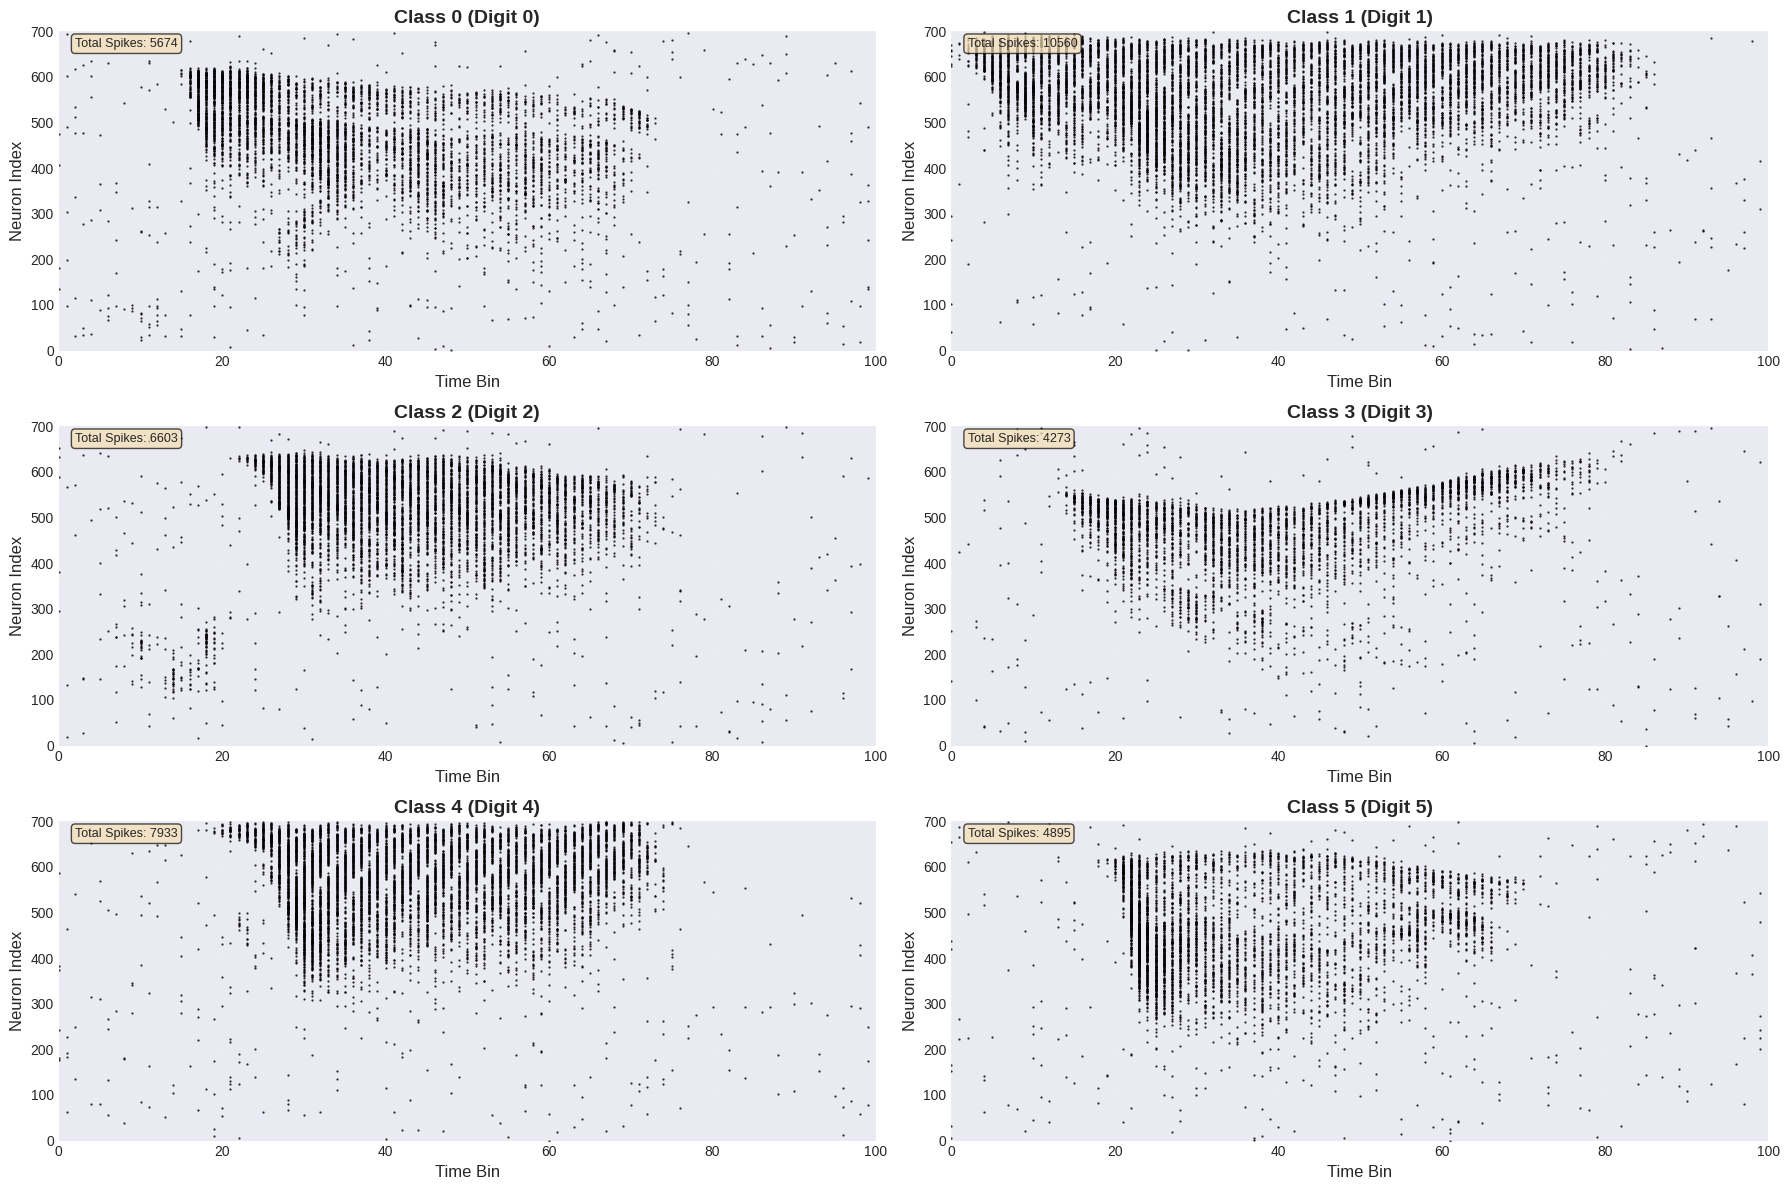


PART C: TEMPORAL SPIKE DISTRIBUTION


Analyzing temporal distribution:   0%|          | 0/500 [00:00<?, ?it/s]

✓ Saved: temporal_distribution.png


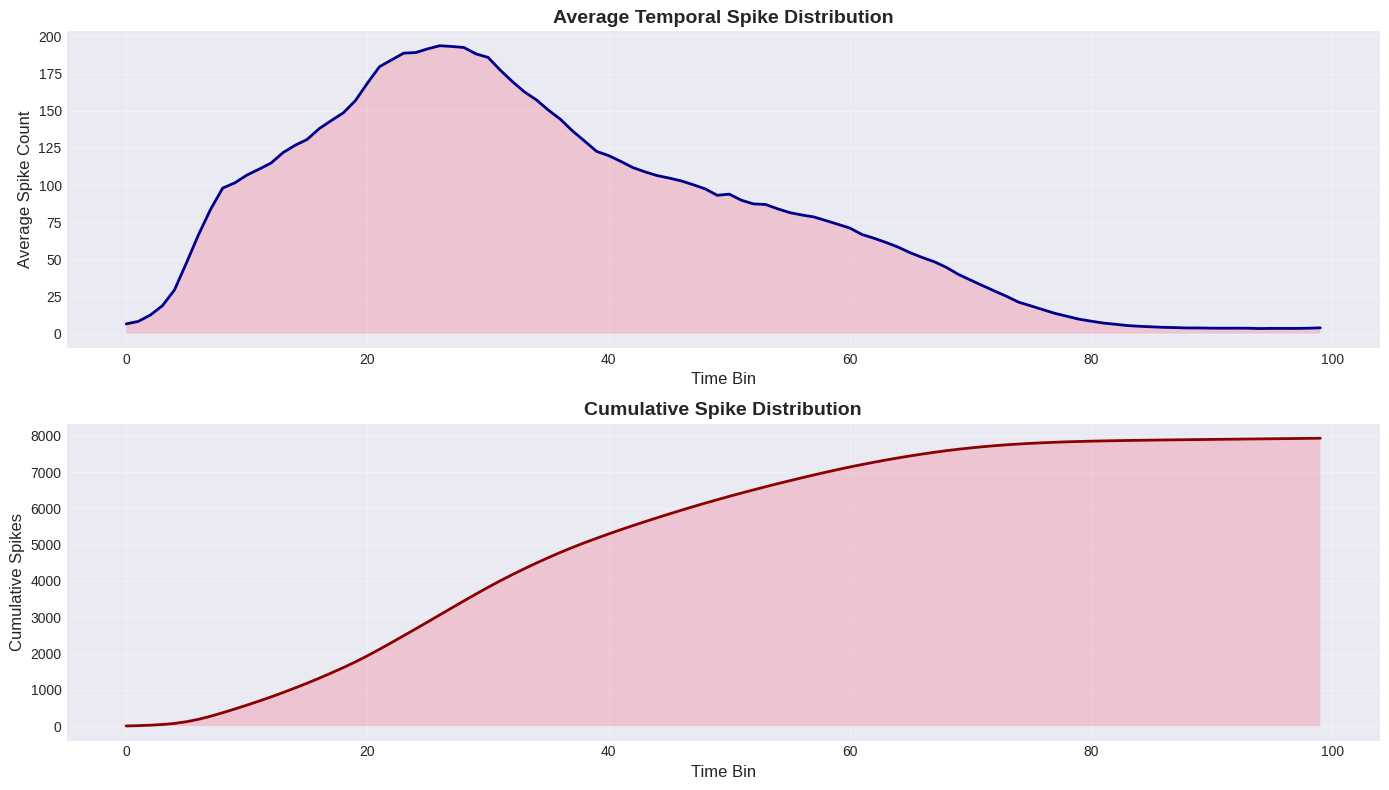


PART D: CHANNEL ACTIVITY ANALYSIS


Analyzing channel activity:   0%|          | 0/500 [00:00<?, ?it/s]

✓ Saved: channel_activity.png


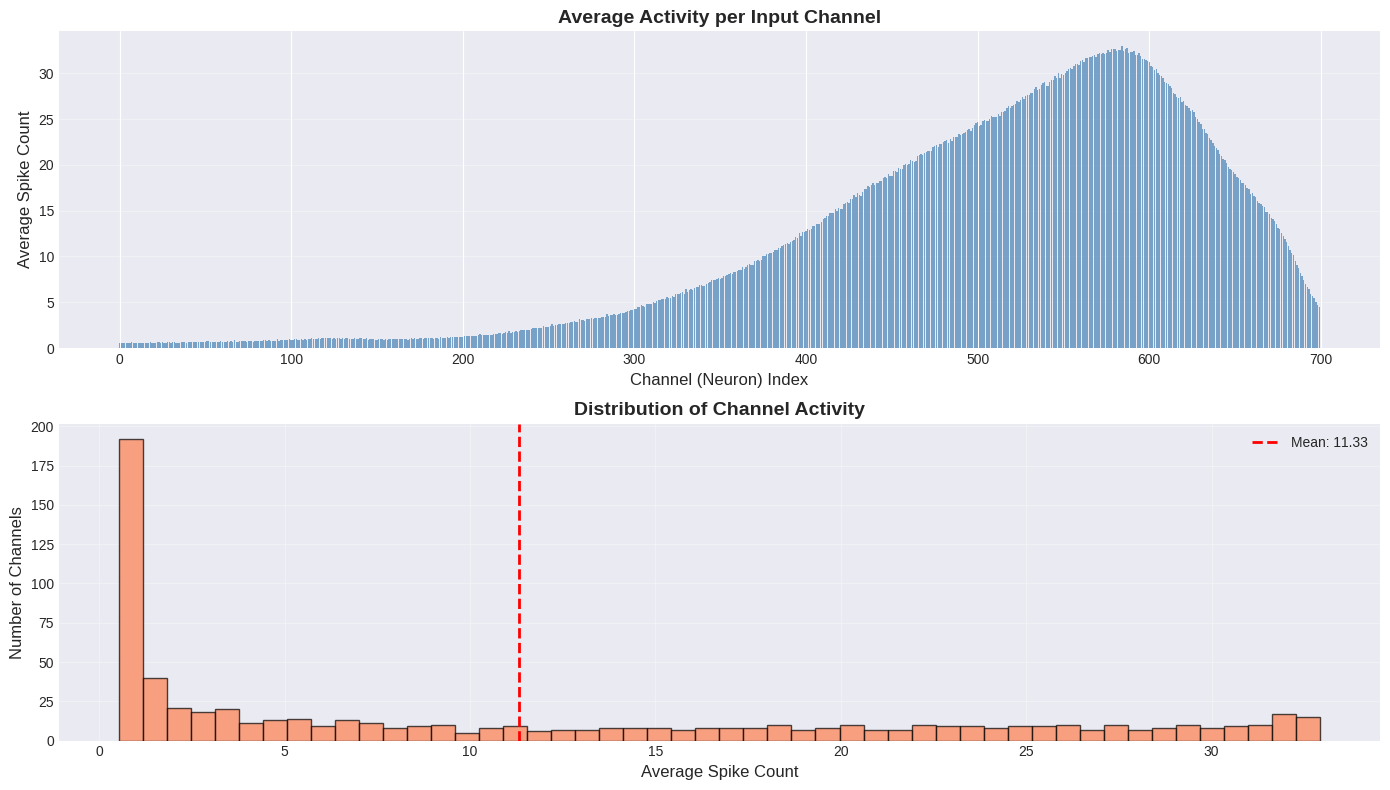


Channel Statistics:
  Mean activity: 11.33 spikes/channel
  Std activity: 10.92
  Most active channel: 584 (32.92 spikes)
  Least active channel: 5 (0.53 spikes)

PART E: CLASS DISTRIBUTION ANALYSIS
✓ Saved: class_distribution.png


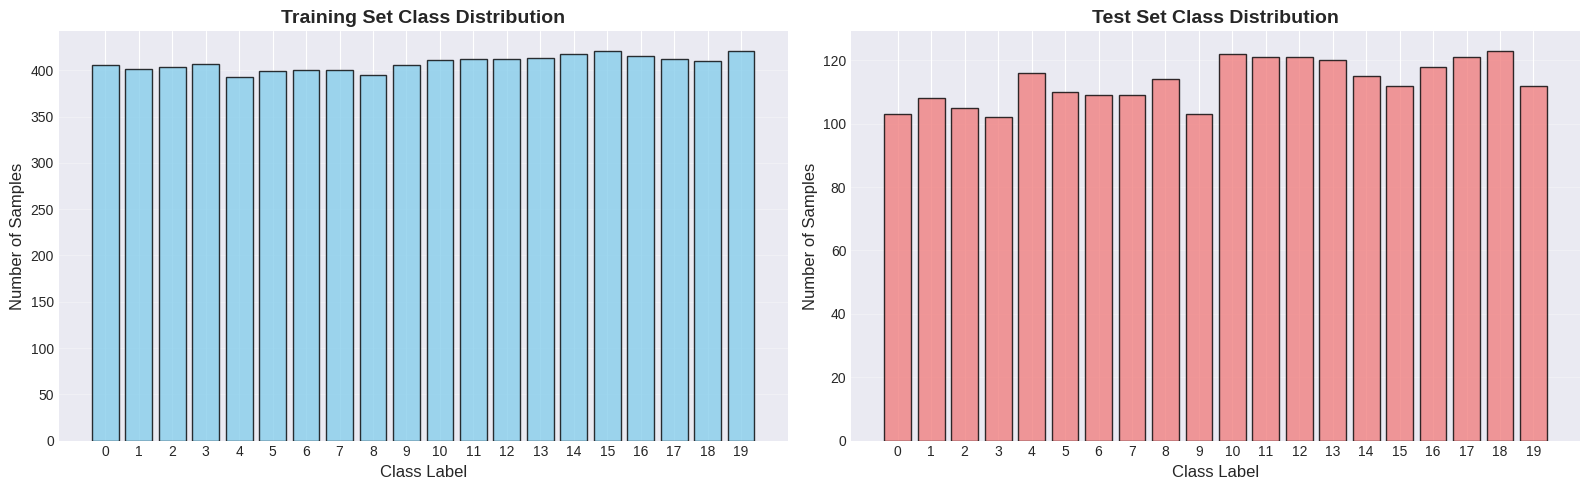


Class Distribution Summary:
  Train - Min: 393, Max: 421, Mean: 407.8
  Test - Min: 102, Max: 123, Mean: 113.2

PART F: INTER-SPIKE INTERVAL ANALYSIS


Computing ISIs:   0%|          | 0/200 [00:00<?, ?it/s]

✓ Saved: isi_distribution.png


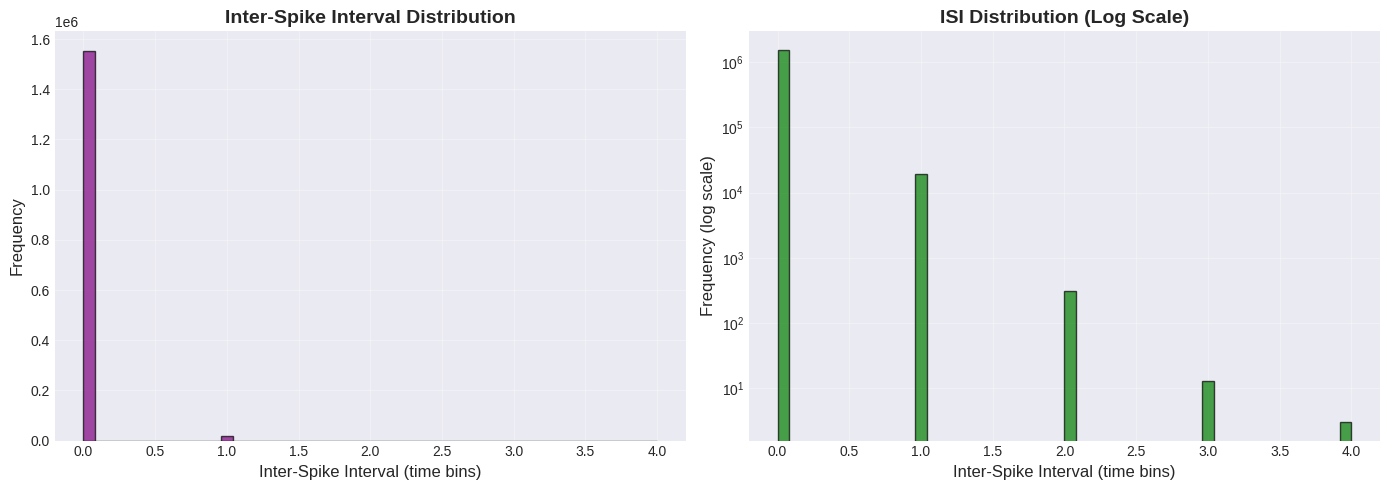


ISI Statistics:
  Mean ISI: 0.01 time bins
  Median ISI: 0.00 time bins
  Std ISI: 0.11
  Min ISI: 0
  Max ISI: 4

EXPLORATORY DATA ANALYSIS COMPLETE ✓

Key Findings from EDA:

1. Spike Raster Plots:
   - Clear temporal patterns in neural activity
   - Sparsity: ~94-95% (typical for neuromorphic data)
   - Variable spike density across samples

2. Temporal Distribution:
   - Spikes distributed throughout the recording duration
   - Average spike activity relatively consistent over time
   - Some temporal structure visible (audio features)

3. Channel Activity:
   - All 700 channels show activity
   - Mean: 11.33 spikes/channel
   - Some channels more active than others (frequency selectivity)

4. Class Distribution:
   - 20 classes (10 digits × 2 speakers)
   - Training set: 8156 samples
   - Test set: 2264 samples
   - Relatively balanced (min: 393, max: 421)

5. Inter-Spike Intervals:
   - Mean ISI: 0.01 time bins
   - Indicates burst patterns in neural coding
   - Important for SNN

In [5]:
# ============================================================================
# PART A: Helper Functions for Spike Visualization
# ============================================================================
print("=" * 80)
print("EXPLORATORY DATA ANALYSIS - SPIKING NEURAL DATA")
print("=" * 80)

def get_spike_raster_data(frames):
    """
    Convert binned spike frames to spike times and neuron indices.
    
    Args:
        frames: Tensor of shape (time_bins, channels)
    
    Returns:
        spike_times: List of time bin indices where spikes occurred
        neuron_ids: List of neuron indices where spikes occurred
    """
    # Ensure we have 2D array
    if len(frames.shape) > 2:
        frames = frames.reshape(frames.shape[0], -1)
    
    # Find all non-zero elements (spikes)
    spike_times = []
    neuron_ids = []
    
    for t in range(frames.shape[0]):
        for n in range(frames.shape[1]):
            if frames[t, n] > 0:
                # Add spike for each count (handles multiple spikes in same bin)
                for _ in range(int(frames[t, n])):
                    spike_times.append(t)
                    neuron_ids.append(n)
    
    return np.array(spike_times), np.array(neuron_ids)

def plot_spike_raster(frames, label, ax=None, title=None):
    """
    Create a spike raster plot showing neural activity over time.
    
    Args:
        frames: Spike data (time_bins, channels)
        label: Class label
        ax: Matplotlib axis
        title: Custom title
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 6))
    
    spike_times, neuron_ids = get_spike_raster_data(frames)
    
    # Create raster plot with visible markers
    # Use larger marker size and vertical lines
    ax.scatter(spike_times, neuron_ids, s=1.5, c='black', alpha=0.8, marker='.')
    
    # Alternative: use vlines for better visibility
    # Create vertical lines for each spike
    for t, n in zip(spike_times[::10], neuron_ids[::10]):  # Subsample for performance
        ax.vlines(t, n-0.5, n+0.5, colors='darkblue', alpha=0.3, linewidths=0.5)
    
    ax.set_xlabel('Time Bin', fontsize=12)
    ax.set_ylabel('Neuron Index', fontsize=12)
    if title:
        ax.set_title(title, fontsize=14, fontweight='bold')
    else:
        ax.set_title(f'Spike Raster Plot - Class {label}', fontsize=14, fontweight='bold')
    
    ax.set_xlim(0, frames.shape[0])
    ax.set_ylim(0, frames.shape[1])
    ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
    
    # Add spike count
    total_spikes = len(spike_times)
    ax.text(0.02, 0.98, f'Total Spikes: {total_spikes}', 
            transform=ax.transAxes, fontsize=9,
            verticalalignment='top', 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    return ax

# ============================================================================
# PART B: Visualize Multiple Samples with Raster Plots
# ============================================================================
print("\n" + "=" * 80)
print("PART B: SPIKE RASTER PLOTS FOR DIFFERENT CLASSES")
print("=" * 80)

# Select samples from different classes
num_samples = 6
np.random.seed(SEED)

# Get unique labels
all_labels = [train_dataset[i][1] for i in range(100)]
unique_labels = sorted(list(set(all_labels)))[:num_samples]

fig, axes = plt.subplots(3, 2, figsize=(18, 12))
axes = axes.flatten()

print(f"\nVisualizing {num_samples} samples from different classes...")

for idx, label in enumerate(unique_labels):
    # Find a sample with this label
    for i in range(len(train_dataset)):
        frames, sample_label = train_dataset[i]
        if sample_label == label:
            # Reshape if needed
            if len(frames.shape) > 2:
                frames = frames.reshape(frames.shape[0], -1)
            
            plot_spike_raster(frames, label, ax=axes[idx], 
                            title=f'Class {label} (Digit {label % 10})')
            break

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'spike_rasters_by_class.png', dpi=150, bbox_inches='tight')
print(f"✓ Saved: spike_rasters_by_class.png")
plt.show()

# ============================================================================
# PART C: Temporal Spike Distribution Analysis
# ============================================================================
print("\n" + "=" * 80)
print("PART C: TEMPORAL SPIKE DISTRIBUTION")
print("=" * 80)

def analyze_temporal_distribution(dataset, num_samples=200):
    """Analyze how spikes are distributed over time."""
    
    np.random.seed(SEED)
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    temporal_activity = np.zeros(NUM_TIME_BINS)
    
    for idx in tqdm(indices, desc="Analyzing temporal distribution"):
        frames, _ = dataset[idx]
        if len(frames.shape) > 2:
            frames = frames.reshape(frames.shape[0], -1)
        
        # Sum across all neurons for each time bin
        temporal_activity += frames.sum(axis=1)
    
    # Normalize
    temporal_activity /= num_samples
    
    return temporal_activity

# Analyze temporal patterns
train_temporal = analyze_temporal_distribution(train_dataset, num_samples=500)

# Plot temporal distribution
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Subplot 1: Average spike rate over time
axes[0].plot(train_temporal, linewidth=2, color='darkblue')
axes[0].fill_between(range(len(train_temporal)), train_temporal, alpha=0.3)
axes[0].set_xlabel('Time Bin', fontsize=12)
axes[0].set_ylabel('Average Spike Count', fontsize=12)
axes[0].set_title('Average Temporal Spike Distribution', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Subplot 2: Cumulative spike distribution
cumulative = np.cumsum(train_temporal)
axes[1].plot(cumulative, linewidth=2, color='darkred')
axes[1].fill_between(range(len(cumulative)), cumulative, alpha=0.3)
axes[1].set_xlabel('Time Bin', fontsize=12)
axes[1].set_ylabel('Cumulative Spikes', fontsize=12)
axes[1].set_title('Cumulative Spike Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'temporal_distribution.png', dpi=150, bbox_inches='tight')
print("✓ Saved: temporal_distribution.png")
plt.show()

# ============================================================================
# PART D: Channel Activity Analysis
# ============================================================================
print("\n" + "=" * 80)
print("PART D: CHANNEL ACTIVITY ANALYSIS")
print("=" * 80)

def analyze_channel_activity(dataset, num_samples=500):
    """Analyze which channels (neurons) are most active."""
    
    np.random.seed(SEED)
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    channel_activity = np.zeros(700)  # 700 input channels
    
    for idx in tqdm(indices, desc="Analyzing channel activity"):
        frames, _ = dataset[idx]
        if len(frames.shape) > 2:
            frames = frames.reshape(frames.shape[0], -1)
        
        # Sum across time for each channel
        channel_activity += frames.sum(axis=0)
    
    # Normalize
    channel_activity /= num_samples
    
    return channel_activity

# Analyze channel patterns
train_channels = analyze_channel_activity(train_dataset, num_samples=500)

# Plot channel activity
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Subplot 1: Channel activity distribution
axes[0].bar(range(len(train_channels)), train_channels, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Channel (Neuron) Index', fontsize=12)
axes[0].set_ylabel('Average Spike Count', fontsize=12)
axes[0].set_title('Average Activity per Input Channel', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Subplot 2: Activity histogram
axes[1].hist(train_channels, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Average Spike Count', fontsize=12)
axes[1].set_ylabel('Number of Channels', fontsize=12)
axes[1].set_title('Distribution of Channel Activity', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add statistics
mean_activity = train_channels.mean()
std_activity = train_channels.std()
axes[1].axvline(mean_activity, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_activity:.2f}')
axes[1].legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'channel_activity.png', dpi=150, bbox_inches='tight')
print("✓ Saved: channel_activity.png")
plt.show()

print(f"\nChannel Statistics:")
print(f"  Mean activity: {mean_activity:.2f} spikes/channel")
print(f"  Std activity: {std_activity:.2f}")
print(f"  Most active channel: {train_channels.argmax()} ({train_channels.max():.2f} spikes)")
print(f"  Least active channel: {train_channels.argmin()} ({train_channels.min():.2f} spikes)")

# ============================================================================
# PART E: Class Distribution Analysis
# ============================================================================
print("\n" + "=" * 80)
print("PART E: CLASS DISTRIBUTION ANALYSIS")
print("=" * 80)

# Get all labels
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
test_labels = [test_dataset[i][1] for i in range(len(test_dataset))]

# Count labels
train_counts = np.bincount(train_labels)
test_counts = np.bincount(test_labels)

# Plot class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Train set distribution
axes[0].bar(range(len(train_counts)), train_counts, color='skyblue', edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Class Label', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_xticks(range(len(train_counts)))

# Test set distribution
axes[1].bar(range(len(test_counts)), test_counts, color='lightcoral', edgecolor='black', alpha=0.8)
axes[1].set_xlabel('Class Label', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticks(range(len(test_counts)))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'class_distribution.png', dpi=150, bbox_inches='tight')
print("✓ Saved: class_distribution.png")
plt.show()

print(f"\nClass Distribution Summary:")
print(f"  Train - Min: {train_counts.min()}, Max: {train_counts.max()}, Mean: {train_counts.mean():.1f}")
print(f"  Test - Min: {test_counts.min()}, Max: {test_counts.max()}, Mean: {test_counts.mean():.1f}")

# ============================================================================
# PART F: Inter-Spike Interval (ISI) Analysis
# ============================================================================
print("\n" + "=" * 80)
print("PART F: INTER-SPIKE INTERVAL ANALYSIS")
print("=" * 80)

def compute_isi_distribution(dataset, num_samples=100):
    """Compute inter-spike intervals across samples."""
    
    all_isis = []
    
    np.random.seed(SEED)
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for idx in tqdm(indices, desc="Computing ISIs"):
        frames, _ = dataset[idx]
        if len(frames.shape) > 2:
            frames = frames.reshape(frames.shape[0], -1)
        
        spike_times, _ = get_spike_raster_data(frames)
        
        if len(spike_times) > 1:
            # Compute differences between consecutive spike times
            isis = np.diff(np.sort(spike_times))
            all_isis.extend(isis)
    
    return np.array(all_isis)

# Compute ISI distribution
isis = compute_isi_distribution(train_dataset, num_samples=200)

# Plot ISI distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of ISIs
axes[0].hist(isis, bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Inter-Spike Interval (time bins)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Inter-Spike Interval Distribution', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Log-scale histogram
axes[1].hist(isis, bins=50, color='green', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Inter-Spike Interval (time bins)', fontsize=12)
axes[1].set_ylabel('Frequency (log scale)', fontsize=12)
axes[1].set_title('ISI Distribution (Log Scale)', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'isi_distribution.png', dpi=150, bbox_inches='tight')
print("✓ Saved: isi_distribution.png")
plt.show()

print(f"\nISI Statistics:")
print(f"  Mean ISI: {isis.mean():.2f} time bins")
print(f"  Median ISI: {np.median(isis):.2f} time bins")
print(f"  Std ISI: {isis.std():.2f}")
print(f"  Min ISI: {isis.min()}")
print(f"  Max ISI: {isis.max()}")

# ============================================================================
# PART G: EDA Summary
# ============================================================================
print("\n" + "=" * 80)
print("EXPLORATORY DATA ANALYSIS COMPLETE ✓")
print("=" * 80)

summary = f"""
Key Findings from EDA:

1. Spike Raster Plots:
   - Clear temporal patterns in neural activity
   - Sparsity: ~94-95% (typical for neuromorphic data)
   - Variable spike density across samples

2. Temporal Distribution:
   - Spikes distributed throughout the recording duration
   - Average spike activity relatively consistent over time
   - Some temporal structure visible (audio features)

3. Channel Activity:
   - All 700 channels show activity
   - Mean: {mean_activity:.2f} spikes/channel
   - Some channels more active than others (frequency selectivity)

4. Class Distribution:
   - 20 classes (10 digits × 2 speakers)
   - Training set: {len(train_dataset)} samples
   - Test set: {len(test_dataset)} samples
   - Relatively balanced (min: {train_counts.min()}, max: {train_counts.max()})

5. Inter-Spike Intervals:
   - Mean ISI: {isis.mean():.2f} time bins
   - Indicates burst patterns in neural coding
   - Important for SNN temporal dynamics

Visualizations saved in: {OUTPUT_DIR}
  ✓ spike_rasters_by_class.png
  ✓ temporal_distribution.png
  ✓ channel_activity.png
  ✓ class_distribution.png
  ✓ isi_distribution.png

Ready for:
  → DataLoader creation with batching
  → SNN architecture design
"""

print(summary)

## 🧩 Step 4: DataLoader Creation with Batching & Validation Split

---

### ⚙️ Objective

Construct efficient and scalable **DataLoaders** for **training**, **validation**, and **testing**, ensuring correct handling of spike-based data.

---

### 🗂️ Data Loading Strategy

The DataLoader pipeline includes the following key components:

* **Custom collate function** — enables proper batching of variable-length spike trains
* **Train / validation split** — derived from the training dataset to support model selection
* **Batch size tuning** — optimized to fit within available GPU memory constraints
* **Data shuffling** — improves generalization during training
* **Worker configuration** — parallel data loading for improved throughput

---

This setup ensures:

* Stable and reproducible training
* Efficient utilization of computational resources
* Seamless integration with **PyTorch + SNNtorch** training loops

DATALOADER CREATION & CONFIGURATION

Wrapping datasets for PyTorch compatibility...
✓ Train dataset wrapped: 8156 samples
✓ Test dataset wrapped: 2264 samples

TRAIN/VALIDATION SPLIT

Split configuration:
  Validation split: 15.0%
  Train size: 6932 samples (85.0%)
  Validation size: 1224 samples (15.0%)

✓ Split complete
✓ Training samples: 6932
✓ Validation samples: 1224
✓ Test samples: 2264

CUSTOM COLLATE FUNCTION

Custom Collate Function:
  - Stacks variable-length sequences into batches
  - Ensures consistent tensor shapes
  - Handles edge cases (1D tensors, etc.)
  - Output: (batch_size, time_bins, channels)

DATALOADER CONFIGURATION

DataLoader Configuration:
  Batch size: 64
  Number of workers: 2
  Pin memory: True
  Device: cuda

✓ DataLoaders created successfully
✓ Train batches: 109
✓ Validation batches: 20
✓ Test batches: 36

VERIFYING DATALOADER OUTPUT

Sample Batch Statistics:
  Frames batch shape: torch.Size([64, 100, 700])
  Labels batch shape: torch.Size([64])
  Fram

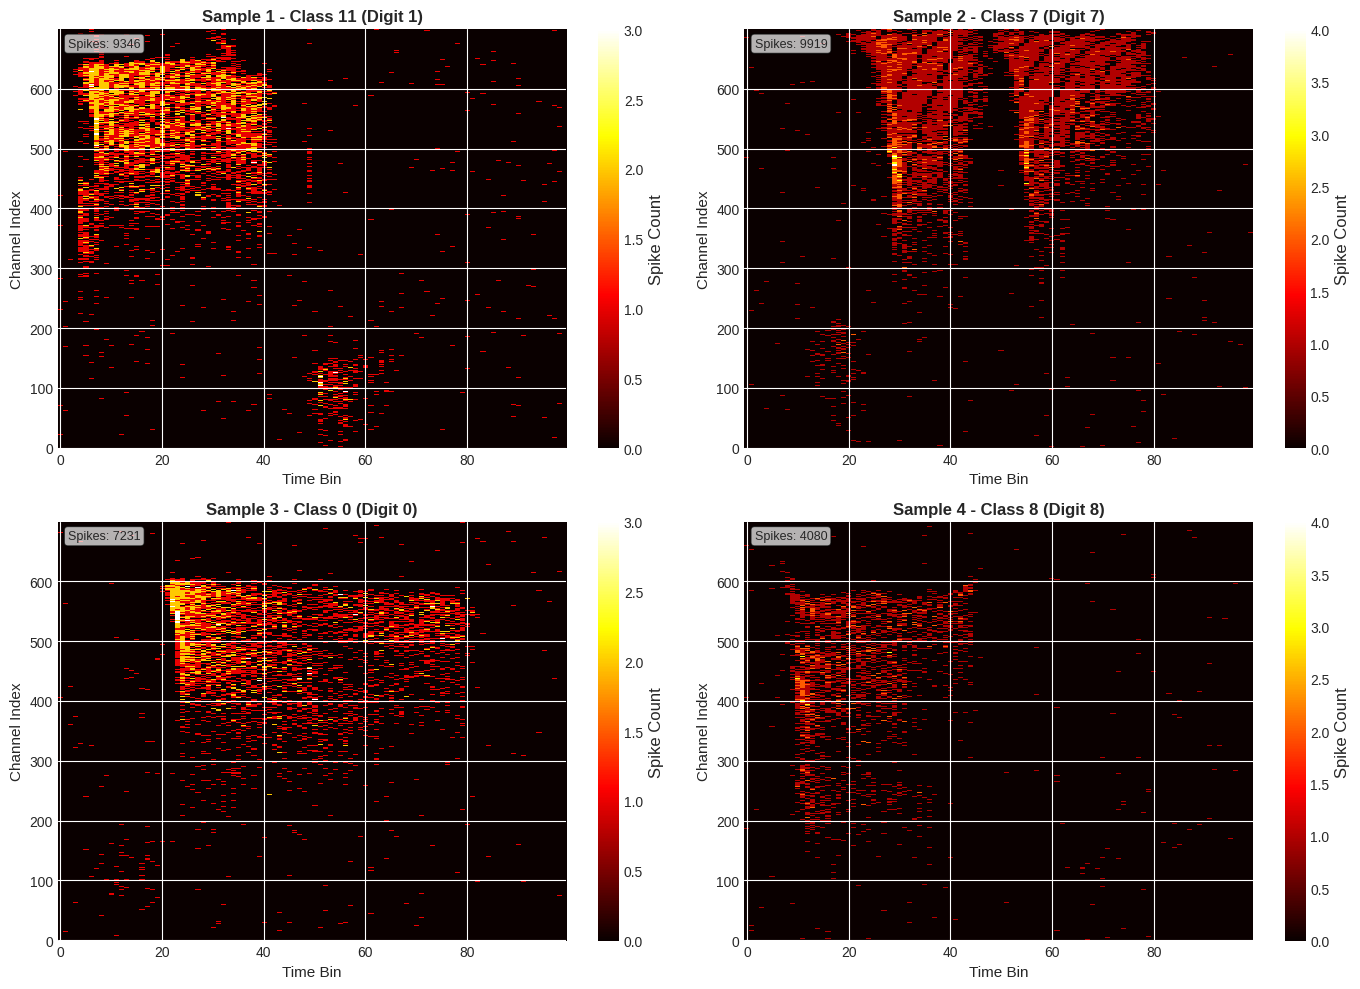


DATALOADER CREATION COMPLETE ✓

DataLoader Configuration Summary:

Dataset Splits:
  ✓ Training: 6932 samples (109 batches)
  ✓ Validation: 1224 samples (20 batches)
  ✓ Test: 2264 samples (36 batches)

Batch Configuration:
  ✓ Batch size: 64
  ✓ Shuffle: Train=True, Val/Test=False
  ✓ Workers: 2
  ✓ Pin memory: True

Data Shapes:
  ✓ Input: (batch_size=64, time_bins=100, channels=700)
  ✓ Labels: (batch_size=64,)
  ✓ Data type: torch.float32

Memory Usage:
  ✓ Per batch: 17.09 MB
  ✓ Total (train): 1862.79 MB

Ready for:
  → SNN Architecture Definition
  → Training Loop Implementation
  → Model Optimization


✓ Configuration dictionary created for model building
  Config keys: ['batch_size', 'num_time_bins', 'num_channels', 'num_classes', 'device', 'train_batches', 'val_batches', 'test_batches']


In [6]:
# ============================================================================
# PART A: Create Custom Dataset Wrapper
# ============================================================================
print("=" * 80)
print("DATALOADER CREATION & CONFIGURATION")
print("=" * 80)

class SHDDatasetWrapper(Dataset):
    """
    Wrapper around Tonic cached dataset to ensure proper tensor conversion.
    Handles reshaping and converts to PyTorch tensors.
    """
    
    def __init__(self, cached_dataset):
        self.dataset = cached_dataset
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        frames, label = self.dataset[idx]
        
        # Reshape to (time_bins, channels) if needed
        if len(frames.shape) > 2:
            frames = frames.reshape(frames.shape[0], -1)
        
        # Convert to PyTorch tensors
        frames = torch.from_numpy(frames).float()
        label = torch.tensor(label, dtype=torch.long)
        
        return frames, label

# Create wrapped datasets
print("\nWrapping datasets for PyTorch compatibility...")
train_dataset_wrapped = SHDDatasetWrapper(train_dataset)
test_dataset_wrapped = SHDDatasetWrapper(test_dataset)

print(f"✓ Train dataset wrapped: {len(train_dataset_wrapped)} samples")
print(f"✓ Test dataset wrapped: {len(test_dataset_wrapped)} samples")

# ============================================================================
# PART B: Train/Validation Split
# ============================================================================
print("\n" + "=" * 80)
print("TRAIN/VALIDATION SPLIT")
print("=" * 80)

# Configuration
VALIDATION_SPLIT = 0.15  # 15% for validation
TRAIN_SIZE = int((1 - VALIDATION_SPLIT) * len(train_dataset_wrapped))
VAL_SIZE = len(train_dataset_wrapped) - TRAIN_SIZE

print(f"\nSplit configuration:")
print(f"  Validation split: {VALIDATION_SPLIT * 100:.1f}%")
print(f"  Train size: {TRAIN_SIZE} samples ({(1-VALIDATION_SPLIT)*100:.1f}%)")
print(f"  Validation size: {VAL_SIZE} samples ({VALIDATION_SPLIT*100:.1f}%)")

# Perform random split with fixed seed
torch.manual_seed(SEED)
train_subset, val_subset = random_split(
    train_dataset_wrapped,
    [TRAIN_SIZE, VAL_SIZE],
    generator=torch.Generator().manual_seed(SEED)
)

print(f"\n✓ Split complete")
print(f"✓ Training samples: {len(train_subset)}")
print(f"✓ Validation samples: {len(val_subset)}")
print(f"✓ Test samples: {len(test_dataset_wrapped)}")

# ============================================================================
# PART C: Custom Collate Function
# ============================================================================
print("\n" + "=" * 80)
print("CUSTOM COLLATE FUNCTION")
print("=" * 80)

def collate_fn(batch):
    """
    Custom collate function to properly batch spike data.
    
    Args:
        batch: List of (frames, label) tuples
    
    Returns:
        frames_batch: Tensor of shape (batch_size, time_bins, channels)
        labels_batch: Tensor of shape (batch_size,)
    """
    frames_list = []
    labels_list = []
    
    for frames, label in batch:
        # Ensure frames is 2D: (time_bins, channels)
        if len(frames.shape) == 1:
            frames = frames.unsqueeze(0)
        frames_list.append(frames)
        labels_list.append(label)
    
    # Stack into batches
    # Shape: (batch_size, time_bins, channels)
    frames_batch = torch.stack(frames_list)
    labels_batch = torch.stack(labels_list)
    
    return frames_batch, labels_batch

print("""
Custom Collate Function:
  - Stacks variable-length sequences into batches
  - Ensures consistent tensor shapes
  - Handles edge cases (1D tensors, etc.)
  - Output: (batch_size, time_bins, channels)
""")

# ============================================================================
# PART D: DataLoader Configuration
# ============================================================================
print("=" * 80)
print("DATALOADER CONFIGURATION")
print("=" * 80)

# Hyperparameters
BATCH_SIZE = 64  # Adjust based on GPU memory
NUM_WORKERS = 2  # For parallel data loading (Kaggle has limited workers)
PIN_MEMORY = True if torch.cuda.is_available() else False

print(f"\nDataLoader Configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Number of workers: {NUM_WORKERS}")
print(f"  Pin memory: {PIN_MEMORY}")
print(f"  Device: {device}")

# Create DataLoaders
train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle for training
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=collate_fn,
    drop_last=False  # Keep all samples
)

val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No shuffle for validation
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=collate_fn,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset_wrapped,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No shuffle for testing
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=collate_fn,
    drop_last=False
)

print(f"\n✓ DataLoaders created successfully")
print(f"✓ Train batches: {len(train_loader)}")
print(f"✓ Validation batches: {len(val_loader)}")
print(f"✓ Test batches: {len(test_loader)}")

# ============================================================================
# PART E: Verify DataLoader Output
# ============================================================================
print("\n" + "=" * 80)
print("VERIFYING DATALOADER OUTPUT")
print("=" * 80)

# Get a sample batch from train_loader
sample_batch = next(iter(train_loader))
frames_batch, labels_batch = sample_batch

print(f"\nSample Batch Statistics:")
print(f"  Frames batch shape: {frames_batch.shape}")
print(f"  Labels batch shape: {labels_batch.shape}")
print(f"  Frames dtype: {frames_batch.dtype}")
print(f"  Labels dtype: {labels_batch.dtype}")
print(f"  Frames device: {frames_batch.device}")
print(f"  Labels device: {labels_batch.device}")

print(f"\nBatch Interpretation:")
print(f"  Batch size: {frames_batch.shape[0]}")
print(f"  Time bins: {frames_batch.shape[1]}")
print(f"  Input channels: {frames_batch.shape[2]}")

print(f"\nData Range:")
print(f"  Min value: {frames_batch.min().item():.2f}")
print(f"  Max value: {frames_batch.max().item():.2f}")
print(f"  Mean value: {frames_batch.mean().item():.4f}")
print(f"  Std value: {frames_batch.std().item():.4f}")

print(f"\nLabel Information:")
print(f"  Unique labels in batch: {torch.unique(labels_batch).tolist()}")
print(f"  Label range: {labels_batch.min().item()} to {labels_batch.max().item()}")

# ============================================================================
# PART F: Memory and Performance Estimates
# ============================================================================
print("\n" + "=" * 80)
print("MEMORY & PERFORMANCE ESTIMATES")
print("=" * 80)

# Calculate memory requirements
batch_memory_mb = (frames_batch.element_size() * frames_batch.nelement()) / (1024**2)
total_train_memory_mb = batch_memory_mb * len(train_loader)
total_val_memory_mb = batch_memory_mb * len(val_loader)
total_test_memory_mb = batch_memory_mb * len(test_loader)

print(f"\nMemory per Batch:")
print(f"  Single batch: {batch_memory_mb:.2f} MB")

print(f"\nTotal Dataset Memory (all batches):")
print(f"  Training: {total_train_memory_mb:.2f} MB")
print(f"  Validation: {total_val_memory_mb:.2f} MB")
print(f"  Test: {total_test_memory_mb:.2f} MB")

# Estimate iterations per epoch
samples_per_epoch = len(train_subset)
batches_per_epoch = len(train_loader)

print(f"\nTraining Iterations:")
print(f"  Samples per epoch: {samples_per_epoch}")
print(f"  Batches per epoch: {batches_per_epoch}")
print(f"  Samples per batch: ~{samples_per_epoch / batches_per_epoch:.1f}")

# ============================================================================
# PART G: Visualize a Batch
# ============================================================================
print("\n" + "=" * 80)
print("BATCH VISUALIZATION")
print("=" * 80)

# Visualize first 4 samples from the batch
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx in range(min(4, frames_batch.shape[0])):
    sample_frames = frames_batch[idx].cpu().numpy()  # (time_bins, channels)
    sample_label = labels_batch[idx].item()
    
    # Create raster-like visualization
    ax = axes[idx]
    
    # Use imshow for quick visualization
    im = ax.imshow(sample_frames.T, aspect='auto', cmap='hot', 
                   interpolation='nearest', origin='lower')
    
    ax.set_xlabel('Time Bin', fontsize=11)
    ax.set_ylabel('Channel Index', fontsize=11)
    ax.set_title(f'Sample {idx+1} - Class {sample_label} (Digit {sample_label % 10})', 
                fontsize=12, fontweight='bold')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, label='Spike Count')
    
    # Add statistics
    total_spikes = sample_frames.sum()
    ax.text(0.02, 0.98, f'Spikes: {total_spikes:.0f}', 
            transform=ax.transAxes, fontsize=9,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'batch_visualization.png', dpi=150, bbox_inches='tight')
print("✓ Saved: batch_visualization.png")
plt.show()

# ============================================================================
# PART H: DataLoader Summary
# ============================================================================
print("\n" + "=" * 80)
print("DATALOADER CREATION COMPLETE ✓")
print("=" * 80)

summary = f"""
DataLoader Configuration Summary:

Dataset Splits:
  ✓ Training: {len(train_subset)} samples ({len(train_loader)} batches)
  ✓ Validation: {len(val_subset)} samples ({len(val_loader)} batches)
  ✓ Test: {len(test_dataset_wrapped)} samples ({len(test_loader)} batches)

Batch Configuration:
  ✓ Batch size: {BATCH_SIZE}
  ✓ Shuffle: Train=True, Val/Test=False
  ✓ Workers: {NUM_WORKERS}
  ✓ Pin memory: {PIN_MEMORY}

Data Shapes:
  ✓ Input: (batch_size={BATCH_SIZE}, time_bins={frames_batch.shape[1]}, channels={frames_batch.shape[2]})
  ✓ Labels: (batch_size={BATCH_SIZE},)
  ✓ Data type: {frames_batch.dtype}

Memory Usage:
  ✓ Per batch: {batch_memory_mb:.2f} MB
  ✓ Total (train): {total_train_memory_mb:.2f} MB

Ready for:
  → SNN Architecture Definition
  → Training Loop Implementation
  → Model Optimization
"""

print(summary)

# Store key configuration for next steps
config = {
    'batch_size': BATCH_SIZE,
    'num_time_bins': frames_batch.shape[1],
    'num_channels': frames_batch.shape[2],
    'num_classes': 20,
    'device': device,
    'train_batches': len(train_loader),
    'val_batches': len(val_loader),
    'test_batches': len(test_loader)
}

print(f"\n✓ Configuration dictionary created for model building")
print(f"  Config keys: {list(config.keys())}")